In [65]:
from torchvision import datasets
from torchvision import transforms

data_path = '../data/'
mnist = datasets.MNIST(data_path, download=True)

In [66]:
mnist.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [67]:
len(mnist)

60000

In [68]:
img, label = mnist[12345]

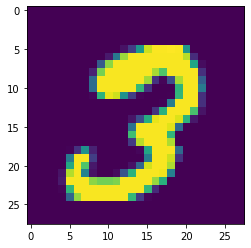

In [69]:
import matplotlib.pyplot as plt
plt.imshow(img)

In [70]:
mnist.classes[label]

'3 - three'

In [71]:
from torchvision import transforms
to_tensor = transforms.ToTensor()
img_t = to_tensor(img)

In [72]:
img_t.shape

torch.Size([1, 28, 28])

In [73]:
img_t.min(), img_t.max()

(tensor(0.), tensor(1.))

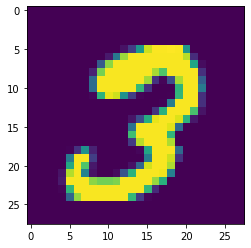

In [74]:
plt.imshow(img_t.permute(1, 2, 0))
plt.show()

In [75]:
import torch
imgs = torch.stack([to_tensor(img_t) for img_t, _ in mnist], dim=3)#%%

In [76]:
imgs.shape

torch.Size([1, 28, 28, 60000])

In [77]:
m = imgs.view(1,-1).mean(dim=1).item()
s = imgs.view(1,-1).std(dim=1).item()
m,s

(0.13066332042217255, 0.30810782313346863)

In [78]:
mnist_train = datasets.MNIST(data_path, train=True, download=True,
                             transform=transforms.Compose(
                                 [transforms.ToTensor(),
                                  transforms.Normalize(m,s)]))
mnist_validate = datasets.MNIST(data_path, train=False, download=True,
                             transform=transforms.Compose(
                                 [transforms.ToTensor(),
                                  transforms.Normalize(m,s)]))

In [79]:
import datetime
def train_model(n_epochs, optimizer, model,
                  loss_fn, train_loader, device):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        loss_rate = 0.0
        train_items_count = len(train_loader)
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device = device), labels.to(device = device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
            loss_rate = loss_train / train_items_count
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_rate))

In [87]:
from torch.utils import data
from torch import nn
from torch import cuda
import torch.nn.functional as F
from torch import optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_loader = data.DataLoader(mnist_train,
                               batch_size=64,
                               shuffle=True,
                               pin_memory=(device.type == 'cuda'))
validation_loader = data.DataLoader(mnist_validate,
                                    batch_size=64,
                                    shuffle=True,
                                    pin_memory=(device.type == 'cuda'))

In [88]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [89]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss().to(device)

In [90]:
train_model(10, optimizer, model, loss_fn, train_loader, device)

2020-10-09 22:12:29.420956 Epoch 1, Training loss 0.5439259656853894
2020-10-09 22:14:05.895157 Epoch 10, Training loss 0.08063362089585441


In [91]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

test(model, device, validation_loader)


Test set: Average loss: 0.0437, Accuracy: 9843/10000 (98%)



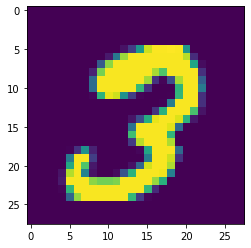

In [93]:
plt.imshow(img)

In [101]:
output = model(torch.stack([to_tensor(img)]).to(device))

In [102]:
output

tensor([[-4.1320, -3.5780, -1.9578, -0.5709, -6.4543, -3.0165, -6.3037, -3.3290,
         -1.9712, -3.8005]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)

In [104]:
pred = output.argmax(dim=1, keepdim=True)
pred

tensor([[3]], device='cuda:0')